# Entity Matching Overview
### Final Project for Kodołamacz's Data Science Bootcamp
Author: Piotr Zioło

### Introduction
Entity matching (also known as record linkage) is the process of identifying which records in two or more datasets refer to the same real-world entity. High-quality entity matching allows organizations to consolidate information, eliminate duplicates, and gain a unified view of their data. Entity matching can be especially important in scenarios such as merging two lists of businesses from different CRMs of companies undergoing a merging process.

In this project, we focus on matching restaurant entities from two restaurant guides: Fodor's and Zagat's. The goal is to determine which entries from the Fodor's restaurant list correspond to the same establishments in the Zagat's list. Since the two sources may use slightly different names, address formats, or phone number conventions for the same restaurant, simple joins on these fields would not guarantee accurate results. Thus, we will compare multiple more advanced approaches to entity matching:
- Fuzzy String Matching – using string similarity (e.g., Levenshtein distance) or token similarity (e.g, token set ratio) on textual fields like name and address.
- TF–IDF + Cosine Similarity – treating restaurant records as documents and measuring cosine similarity of TF-IDF feature vectors.
- Transformer Embeddings + Cosine – using pre-trained language model embeddings (Sentence-BERT) for each record and measuring vector cosine similarity.
- Large Language Model – leveraging an LLM via API to compare restaurant entries and decide if two descriptions refer to the same one.
- Supervised Machine Learning – training a classifier on labeled matching andnon-matching record pairs, using multiple features (text similarity scores, etc.).

We will evaluate each method on accuracy, precision, recall, and F1-score for identifying matches. We will also compare their runtime performance, scalability, and cost. By the end, we should understand which approach works best for this scenario and what the considerations are for deploying each at scale.

### Dataset Overview
The Fodor's–Zagat's restaurant dataset is a dataset designed to serve as a benchmark for entity matching evaluations. It was put together by Anna Primpeli and Christian Bizer of University of Mannheim in Germany.

It consists of two lists of restaurants, one from Fodor's (533 entries) and one from Zagat's (331 entries). Each restaurant has the following attributes:
- id (a unique identifier in each data source)
- name
- addr
- city
- phone
- type (cuisine/category of restaurant)

In addition to the two source lists, there is a gold standard file that indicates which Fodor's and Zagat's records refer to the same real-world restaurant. It includes 112 matching pairs (true matches) and 488 non-matching pairs (true negatives) that have been manually annotated.

The original dataset is available through the Linkage Library (University of Michigan ICPSR) under the project “Restaurants (Fodors-Zagats), Augmented Version, Fixed Splits (ICPSR 127242)”: https://linkagelibrary.icpsr.umich.edu/linkagelibrary/project/127242/version/V1/view?path=/linkagelibrary/127242/fcr:versions/V1/restaurants_-Fodors-Zagats-&type=folder#tab-dataDocs. For the ease of use, all files used in the analysis have been included in the repository.

### Data Loading and Preprocessing


In [2]:
import pandas as pd

# Load datasets
fodors = pd.read_csv(
    'data/fodors.csv', 
    # index_col=0, # Leave id column as a regular column to simplify merging in later steps
    usecols=lambda x: x != 'class', # Exclude 'class' column which is irrelevant to the analysis
    quotechar="'", # Ensure apostrophes are properly interpreted
    escapechar='\\'
)

zagats = pd.read_csv(
    'data/zagats.csv',
    # index_col=0, 
    usecols=lambda x: x != 'class',
    quotechar="'",
    escapechar='\\'
)

matches = pd.read_csv('data/matches_fodors_zagats.csv')

print(f"Fodor's preview: {fodors.shape[0] } rows, {fodors.shape[1]} columns")
print(fodors.head(5))
print()

print(f"Zagat's preview: {zagats.shape[0] } rows, {zagats.shape[1]} columns")
print(zagats.head(5))
print()

print(f"Gold standard matches preview: {matches.shape[0] } rows, {matches.shape[1]} columns")
print(matches.head(5))
print()


Fodor's preview: 533 rows, 6 columns
    id                       name                    addr          city  \
0  534  arnie morton's of chicago  435 s. la cienega blv.   los angeles   
1  535         art's delicatessen     12224 ventura blvd.   studio city   
2  536              hotel bel-air    701 stone canyon rd.       bel air   
3  537                 cafe bizou     14016 ventura blvd.  sherman oaks   
4  538                  campanile     624 s. la brea ave.   los angeles   

          phone         type  
0  310/246-1501     american  
1  818/762-1221     american  
2  310/472-1211  californian  
3  818/788-3536       french  
4  213/938-1447     american  

Zagat's preview: 331 rows, 6 columns
   id             name                            addr              city  \
0   1   apple pan  the             10801 w. pico blvd.           west la   
1   2      asahi ramen             2027 sawtelle blvd.           west la   
2   3       baja fresh                 3345 kimber dr.  west

In [3]:
# Clean and standardize string fields 
# to ensure consistency and improve the effectiveness of similarity algorithms
def preprocess(df, columns):
    df = df.copy()
    for col in columns:
        df[col] = (
            df[col].astype(str) # Ensure all values are strings
                   .str.lower() # Convert to lowercase
                   .str.replace(r'[^a-z0-9\s]', '', regex=True) # Remove special characters
                   .str.replace(r'\s+', ' ', regex=True) # Replace multiple spaces with a single space
                   .str.strip() # Remove leading/trailing whitespace
        )
    return df

columns_to_preprocess = ['name', 'addr', 'city', 'type']

fodors = preprocess(fodors, columns_to_preprocess)
zagats = preprocess(zagats, columns_to_preprocess)

### Method 0: Regular joins
How many restaurants would get matched if we naively used exact matches of names, address, and city?

In [ ]:
# Perform the exact match join with name, address, and city
matched_df = fodors.merge(
    zagats,
    on=['name', 'addr', 'city'],
    how='inner',
    suffixes=('_fodors', '_zagats')
)

# Check against gold standard matches
matched_df['in_gold_standard'] = matched_df.apply(
    lambda row: ((matches['fodors_id'] == row['id_fodors']) & 
                 (matches['zagats_id'] == row['id_zagats'])).any(), axis=1
)

# Summarize the results
total_matched = len(matched_df)
matched_in_gold = matched_df['in_gold_standard'].sum()

print(f"Total exact matches found: {total_matched}")
print(f"Matches present in gold standard: {matched_in_gold}")
print(f"Matches NOT present in gold standard: {total_matched - matched_in_gold}")

Total exact matches found: 26
Matches present in gold standard: 26
Matches NOT present in gold standard: 0


With regular joins, we would only find 26 matches out of all 112 verified matches (23% of all). Thus, searching for a more efficient method that would take discrepancies in the fields used for matching into account is desirable.

### Method 1a: Fuzzy Matching with Levenshtein distance
Fuzzy matching is a text-matching technique used to identify similar strings by directly comparing their textual similarity, even if they are not exactly identical. It relies purely on character-level or token-level string comparisons.

First, we'll use Levenshtein distance which measures the minimum number of single-character edits (insertions, deletions, substitutions) needed to convert one string into another.

Levenshtein distance directly compares the strings character-by-character without accounting for token ordering or semantic similarity. Thus, it's sensitive to word order, length differences, and spelling variations.

In [ ]:
# First, create reusable functions for all later steps

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Generate all possible matching pairs for restaurants in both datasets
# with a customizable similarity function and columns to compare
# Note: This function would be computationally expensive for large datasets
def generate_matching_pairs(df1, df2, similarity_func, cols=['name', 'addr', 'city'], desc='Generating pairs'):
    pairs = []
    for i, row1 in tqdm(df1.iterrows(), total=len(df1), desc=desc):
        for j, row2 in df2.iterrows():
            scores = [similarity_func(row1[col], row2[col]) for col in cols]
            avg_score = np.mean(scores)
            pairs.append({
                'fodors_id': row1['id'],
                'zagats_id': row2['id'],
                'score': avg_score
            })
    return pd.DataFrame(pairs)

# Add ground truth labels to dataframe
def add_ground_truth_labels(df, matches_df):
    match_set = set(zip(matches_df['fodors_id'], matches_df['zagats_id']))
    df['actual_match'] = df.apply(
        lambda row: (row['fodors_id'], row['zagats_id']) in match_set,
        axis=1
    )
    return df

# Optimize threshold for the best F1-score
def optimize_threshold(df, thresholds=np.arange(60, 100, 1), desc="Optimizing threshold"):
    best_f1, best_threshold = 0, 0
    for threshold in tqdm(thresholds, desc=desc):
        df['predicted_match'] = df['score'] >= threshold
        f1 = f1_score(df['actual_match'], df['predicted_match'])
        if f1 > best_f1:
            best_f1, best_threshold = f1, threshold
    
    df['predicted_match'] = df['score'] >= best_threshold
    precision = precision_score(df['actual_match'], df['predicted_match'])
    recall = recall_score(df['actual_match'], df['predicted_match'])
    accuracy = accuracy_score(df['actual_match'], df['predicted_match'])

    metrics = {
        'best_threshold': best_threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': best_f1,
        'accuracy': accuracy
    }

    return df, metrics

# View results with four possible classification outcomes:
# True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN)
# TP: Actual match and predicted match
# TN: Actual non-match and predicted non-match
# FP: Actual non-match but predicted match
# FN: Actual match but predicted non-match
def preview_classification_outcomes(df, fodors, zagats, num_samples=5):
    # Define classification outcomes
    conditions = [
        (df['actual_match'] == True) & (df['predicted_match'] == True),
        (df['actual_match'] == False) & (df['predicted_match'] == False),
        (df['actual_match'] == False) & (df['predicted_match'] == True),
        (df['actual_match'] == True) & (df['predicted_match'] == False),
    ]
    outcomes = ['TP', 'TN', 'FP', 'FN']
    df['classification'] = np.select(conditions, outcomes)

    # Preview each classification outcome
    for outcome in outcomes:
        subset = df[df['classification'] == outcome].head(num_samples)
        merged_df = subset.merge(fodors, left_on='fodors_id', right_on='id', suffixes=('', '_fodors')) \
                          .merge(zagats, left_on='zagats_id', right_on='id', suffixes=('_fodors', '_zagats'))

        display_cols = [
            'name_fodors', 'addr_fodors', 'city_fodors',
            'name_zagats', 'addr_zagats', 'city_zagats',
            'score', 'actual_match', 'predicted_match'
        ]
        print(f"\n{outcome} examples:")
        display(merged_df[display_cols])


In [ ]:
from Levenshtein import distance as levenshtein_distance

# Normalized Levenshtein similarity
def normalized_levenshtein(s1, s2):
    dist = levenshtein_distance(s1, s2)
    max_len = max(len(s1), len(s2))
    if max_len == 0:
        return 100
    return 100 * (1 - dist / max_len)

# Generate pairs
lev_df = generate_matching_pairs(
    fodors, zagats,
    similarity_func=normalized_levenshtein,
    desc='Levenshtein scoring'
)

# Add ground truth labels
lev_df = add_ground_truth_labels(lev_df, matches)

print(f"\nLevenshtein pairs preview: {lev_df.shape[0]} rows, {lev_df.shape[1]} columns")
print(lev_df.head())

# Find best threshold
lev_df, lev_metrics = optimize_threshold(
    lev_df,
    thresholds=np.arange(60, 100, 1),
    desc="Optimizing Levenshtein threshold"
)

# Results
print(f"\nOptimized Levenshtein Threshold: {lev_metrics['best_threshold']}")
print("Levenshtein Matching Results:")
print(f"Precision: {lev_metrics['precision']:.2f}")
print(f"Recall:    {lev_metrics['recall']:.2f}")
print(f"F1-Score:  {lev_metrics['f1_score']:.2f}")
print(f"Accuracy:  {lev_metrics['accuracy']:.2f}")


Levenshtein scoring: 100%|██████████| 533/533 [00:13<00:00, 39.70it/s]



Levenshtein pairs preview: 176423 rows, 4 columns
   fodors_id  zagats_id      score  actual_match
0        534          1  24.393939         False
1        534          2  20.227273         False
2        534          3  20.138889         False
3        534          4  21.028588         False
4        534          5  19.746377         False


Optimizing Levenshtein threshold: 100%|██████████| 40/40 [00:00<00:00, 43.62it/s]


Optimized Levenshtein Threshold: 78
Levenshtein Matching Results:
Precision: 0.97
Recall:    0.69
F1-Score:  0.81
Accuracy:  1.00


In [6]:
# View examples of correctly and incorrectly predicted matches
# split by classification outcome: True Positive, True Negative, False Positive, False Negative
preview_classification_outcomes(lev_df, fodors, zagats)




TP examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,arnie mortons of chicago,435 s la cienega blv,los angeles,arnie mortons of chicago,435 s la cienega blvd,los angeles,98.412698,True,True
1,arts delicatessen,12224 ventura blvd,studio city,arts deli,12224 ventura blvd,studio city,84.313725,True,True
2,cafe bizou,14016 ventura blvd,sherman oaks,cafe bizou,14016 ventura blvd,sherman oaks,100.000000,True,True
3,campanile,624 s la brea ave,los angeles,campanile,624 s la brea ave,los angeles,100.000000,True,True
4,chinois on main,2709 main st,santa monica,chinois on main,2709 main st,santa monica,100.000000,True,True



TN examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,arnie mortons of chicago,435 s la cienega blv,los angeles,apple pan the,10801 w pico blvd,west la,24.393939,False,False
1,arnie mortons of chicago,435 s la cienega blv,los angeles,asahi ramen,2027 sawtelle blvd,west la,20.227273,False,False
2,arnie mortons of chicago,435 s la cienega blv,los angeles,baja fresh,3345 kimber dr,westlake village,20.138889,False,False
3,arnie mortons of chicago,435 s la cienega blv,los angeles,belvedere the,9882 little santa monica blvd,beverly hills,21.028588,False,False
4,arnie mortons of chicago,435 s la cienega blv,los angeles,benitas frites,1433 third st promenade,santa monica,19.746377,False,False



FP examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,restaurant ritzcarlton atlanta,181 peachtree st,atlanta,ritzcarlton cafe atlanta,181 peachtree st,atlanta,82.222222,False,True
1,empress court,3570 las vegas blvd s,las vegas,palace court,3570 las vegas blvd s,las vegas,82.051282,False,True



FN examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,hotel belair,701 stone canyon rd,bel air,belair hotel,701 stone canyon rd,bel air,66.666667,True,False
1,fenix,8358 sunset blvd west,hollywood,fenix at the argyle,8358 sunset blvd,w hollywood,61.441482,True,False
2,grill on the alley,9560 dayton way,los angeles,grill the,9560 dayton way,beverly hills,55.128205,True,False
3,restaurant katsu,1972 n hillhurst ave,los angeles,katsu,1972 hillhurst ave,los feliz,58.598485,True,False
4,lorangerie,903 n la cienega blvd,los angeles,lorangerie,903 n la cienega blvd,w hollywood,66.666667,True,False


As expected, Levenshtein scores did well when names, address and cities were either the same or slightly different becuase of typos or spelling. It failed, though, when parts of the strings were ordered differently or missing.

### Method 1b: Fuzzy Matching with token comparison
Next, we use the Python library fuzzywuzzy, specifically the token_set_ratio function, because it efficiently handles variations in word order, extra or missing words, and minor textual differences by comparing sets of words (tokens) between strings.

This method is particularly effective for quickly identifying matches when differences are mainly textual rather than semantic or context-based, which are common in the restaurant dataset used in this analysis, for example, matching "Palm Restaurant" with "The Palm Restaurant".

In [ ]:
from fuzzywuzzy import fuzz

# Generate pairs
fuzzy_df = generate_matching_pairs(
    fodors, zagats,
    similarity_func=fuzz.token_set_ratio,
    desc='Generating token set ratio scores'
)

# Add ground truth labels
fuzzy_df = add_ground_truth_labels(fuzzy_df, matches)

print(f"\nFuzzy pairs preview: {fuzzy_df.shape[0]} rows, {fuzzy_df.shape[1]} columns")
print(fuzzy_df.head())

# Find best threshold
fuzzy_df, fuzzy_metrics = optimize_threshold(
    fuzzy_df,
    thresholds=np.arange(60, 100, 1),
    desc='Optimizing token set ratio threshold'
)

# Results
print(f"\nOptimized Token Set Ratio Threshold: {fuzzy_metrics['best_threshold']}")
print("Fuzzy Matching Results:")
print(f"Precision: {fuzzy_metrics['precision']:.2f}")
print(f"Recall:    {fuzzy_metrics['recall']:.2f}")
print(f"F1-Score:  {fuzzy_metrics['f1_score']:.2f}")
print(f"Accuracy:  {fuzzy_metrics['accuracy']:.2f}")


Generating token set ratio scores: 100%|██████████| 533/533 [00:24<00:00, 21.97it/s]



Fuzzy pairs preview: 176423 rows, 4 columns
   fodors_id  zagats_id      score  actual_match
0        534          1  34.333333         False
1        534          2  34.666667         False
2        534          3  36.000000         False
3        534          4  36.333333         False
4        534          5  33.333333         False


Optimizing token set ratio threshold: 100%|██████████| 40/40 [00:00<00:00, 41.53it/s]


Optimized Token Set Ratio Threshold: 88
Fuzzy Matching Results:
Precision: 0.96
Recall:    0.89
F1-Score:  0.93
Accuracy:  1.00


In [76]:
preview_classification_outcomes(fuzzy_df, fodors, zagats)


TP examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,arnie mortons of chicago,435 s la cienega blv,los angeles,arnie mortons of chicago,435 s la cienega blvd,los angeles,99.333333,True,True
1,arts delicatessen,12224 ventura blvd,studio city,arts deli,12224 ventura blvd,studio city,89.666667,True,True
2,hotel belair,701 stone canyon rd,bel air,belair hotel,701 stone canyon rd,bel air,100.000000,True,True
3,cafe bizou,14016 ventura blvd,sherman oaks,cafe bizou,14016 ventura blvd,sherman oaks,100.000000,True,True
4,campanile,624 s la brea ave,los angeles,campanile,624 s la brea ave,los angeles,100.000000,True,True



TN examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,arnie mortons of chicago,435 s la cienega blv,los angeles,apple pan the,10801 w pico blvd,west la,31.000000,False,False
1,arnie mortons of chicago,435 s la cienega blv,los angeles,asahi ramen,2027 sawtelle blvd,west la,33.000000,False,False
2,arnie mortons of chicago,435 s la cienega blv,los angeles,baja fresh,3345 kimber dr,westlake village,32.333333,False,False
3,arnie mortons of chicago,435 s la cienega blv,los angeles,belvedere the,9882 little santa monica blvd,beverly hills,28.000000,False,False
4,arnie mortons of chicago,435 s la cienega blv,los angeles,benitas frites,1433 third st promenade,santa monica,28.666667,False,False



FP examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,cafe ritzcarlton buckhead,3434 peachtree rd,atlanta,ritzcarlton dining room buckhead,3434 peachtree rd ne,atlanta,96.333333,False,True
1,dining room ritzcarlton buckhead,3434 peachtree rd,atlanta,ritzcarlton cafe buckhead,3434 peachtree rd ne,atlanta,96.333333,False,True
2,restaurant ritzcarlton atlanta,181 peachtree st,atlanta,ritzcarlton cafe atlanta,181 peachtree st,atlanta,96.000000,False,True



FN examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,grill on the alley,9560 dayton way,los angeles,grill the,9560 dayton way,beverly hills,75.000000,True,False
1,restaurant katsu,1972 n hillhurst ave,los angeles,katsu,1972 hillhurst ave,los feliz,86.666667,True,False
2,lorangerie,903 n la cienega blvd,los angeles,lorangerie,903 n la cienega blvd,w hollywood,72.666667,True,False
3,locanda veneta,3rd st,los angeles,locanda veneta,8638 w third st,los angeles,85.666667,True,False
4,the palm,9001 santa monica blvd,los angeles,palm the los angeles,9001 santa monica blvd,w hollywood,72.666667,True,False


While the token set ratio method proved better than Levenshtein scores (e.g., the F1-score grew from 81% to 93% thanks to a much better recall rate), there still was a relatively high number of false negative matches, which seem to be driven by the differences in city names. While Fodor's marks restaurants as located in Los Angeles, Zagat's locations are more granular and refer to districts, such as Beverly Hills or West Hollywood.

To alleviate that, we could try to standardize city names, i.e. bring them all to the same baseline like large metropolitan area or individual districts, but this approach could be hard to scale with large datasets with data all over the world. Thus, let's review matching methods that take into account word meaning and context.

### Method 2: TF-IDF Vectorization + Cosine Similarity
TF-IDF stands for Term Frequency-Inverse Document Frequency. This vectorization method transforms text data into numerical vectors that represent the importance of words within documents. TF-IDF considers the frequency and uniqueness of words across the entire dataset, rather than just directly comparing individual strings. This makes it more context-aware and less sensitive to minor spelling or token-order differences.

In our case, we'll use sklearn's TfidVectorizer which first tokenizes the text into words, calculates how frequently each word appears within individual records (term frequency), and adjusts those values by how common each word is across all records (inverse document frequency), resulting in vectors emphasizing unique and informative terms.

Then, cosine similarity measures how similar two vectors (records) are by computing the cosine of the angle between them. A cosine similarity close to 1 indicates high similarity (almost identical records), while a score close to 0 indicates low similarity.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine relevant fields
fodors['combined'] = fodors['name'] + ' ' + fodors['addr'] + ' ' + fodors['city']
zagats['combined'] = zagats['name'] + ' ' + zagats['addr'] + ' ' + zagats['city']

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(pd.concat([fodors['combined'], zagats['combined']]))

fodors_tfidf = tfidf_matrix[:len(fodors)]
zagats_tfidf = tfidf_matrix[len(fodors):]

# Cosine similarity calculation
cosine_sim = cosine_similarity(fodors_tfidf, zagats_tfidf)

# Reformat similarity matrix into pairs DataFrame to make output consistent with previous methods
fodors_ids = fodors['id'].values
zagats_ids = zagats['id'].values

pairs = []
for i in tqdm(range(len(fodors_ids)), desc='Generating TF-IDF Cosine similarity pairs'):
    for j in range(len(zagats_ids)):
        pairs.append({
            'fodors_id': fodors_ids[i],
            'zagats_id': zagats_ids[j],
            'score': cosine_sim[i, j]
        })

tfidf_df = pd.DataFrame(pairs)

# Reuse previously defined functions to add ground truth labels
tfidf_df = add_ground_truth_labels(tfidf_df, matches)

# Find best threshold
thresholds = np.arange(0.5, 1.0, 0.01)
tfidf_df, tfidf_metrics = optimize_threshold(
    tfidf_df,
    thresholds=thresholds,
    desc='Optimizing TF-IDF Cosine threshold'
)

# Display final metrics
print(f"\nTF-IDF + Cosine Similarity Matching Results:")
print(f"Optimized Threshold: {tfidf_metrics['best_threshold']:.2f}")
print(f"Precision: {tfidf_metrics['precision']:.2f}")
print(f"Recall:    {tfidf_metrics['recall']:.2f}")
print(f"F1-Score:  {tfidf_metrics['f1_score']:.2f}")
print(f"Accuracy:  {tfidf_metrics['accuracy']:.2f}")


Optimizing TF-IDF Cosine threshold: 100%|██████████| 50/50 [00:01<00:00, 41.39it/s]


TF-IDF + Cosine Similarity Matching Results:
Optimized Threshold: 0.65
Precision: 0.86
Recall:    0.93
F1-Score:  0.89
Accuracy:  1.00


In [10]:
preview_classification_outcomes(tfidf_df, fodors, zagats)


TP examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,arnie mortons of chicago,435 s la cienega blv,los angeles,arnie mortons of chicago,435 s la cienega blvd,los angeles,0.895731,True,True
1,arts delicatessen,12224 ventura blvd,studio city,arts deli,12224 ventura blvd,studio city,0.810901,True,True
2,hotel belair,701 stone canyon rd,bel air,belair hotel,701 stone canyon rd,bel air,1.000000,True,True
3,cafe bizou,14016 ventura blvd,sherman oaks,cafe bizou,14016 ventura blvd,sherman oaks,1.000000,True,True
4,campanile,624 s la brea ave,los angeles,campanile,624 s la brea ave,los angeles,1.000000,True,True



TN examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,arnie mortons of chicago,435 s la cienega blv,los angeles,apple pan the,10801 w pico blvd,west la,0.052879,False,False
1,arnie mortons of chicago,435 s la cienega blv,los angeles,asahi ramen,2027 sawtelle blvd,west la,0.052149,False,False
2,arnie mortons of chicago,435 s la cienega blv,los angeles,baja fresh,3345 kimber dr,westlake village,0.000000,False,False
3,arnie mortons of chicago,435 s la cienega blv,los angeles,belvedere the,9882 little santa monica blvd,beverly hills,0.000000,False,False
4,arnie mortons of chicago,435 s la cienega blv,los angeles,benitas frites,1433 third st promenade,santa monica,0.000000,False,False



FP examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,chins,3200 las vegas blvd s,las vegas,mortons of chicago las vegas,3200 las vegas blvd s,las vegas,0.750678,False,True
1,coyote cafe,3799 las vegas blvd s,las vegas,tre visi,3799 las vegas blvd s,las vegas,0.662837,False,True
2,cafe ritzcarlton buckhead,3434 peachtree rd,atlanta,ritzcarlton dining room buckhead,3434 peachtree rd ne,atlanta,0.741368,False,True
3,dining room ritzcarlton buckhead,3434 peachtree rd,atlanta,ritzcarlton cafe buckhead,3434 peachtree rd ne,atlanta,0.725732,False,True
4,restaurant ritzcarlton atlanta,181 peachtree st,atlanta,ritzcarlton cafe atlanta,181 peachtree st,atlanta,0.885011,False,True



FN examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,philippes the original,1001 n alameda st,los angeles,philippe the original,1001 n alameda st,chinatown,0.636315,True,False
1,spago,1114 horn ave,los angeles,spago los angeles,8795 sunset blvd,w hollywood,0.359161,True,False
2,carnegie deli,854 7th ave between 54th and 55th sts,new york,carnegie deli,854 seventh ave,new york city,0.608640,True,False
3,les celebrites,160 central park s,new york,les celebrites,155 w 58th st,new york city,0.539421,True,False
4,mesa grill,102 5th ave between 15th and 16th sts,new york,mesa grill,102 fifth ave,new york city,0.558394,True,False


<!---
TODO: Describe findings
-->

### Method 3: Sentence-BERT Embeddings + Cosine Similarity
Sentence-BERT (SBERT) generates embeddings, i.e., dense numerical vectors that capture the semantic meaning of sentences or phrases. Unlike TF-IDF, SBERT embeddings are trained to understand the underlying context and semantics of words and sentences, rather than just word frequency.

In our case, we'll use the pre-trained model all-MiniLM-L6-v2 from the sentence-transformers library to encode restaurant records into embeddings. Then, cosine similarity measures how similar two embeddings (records) are by computing the cosine of the angle between them just like for TF-IDF. A cosine similarity close to 1 indicates high semantic similarity (records likely referring to the same entity), while a score close to 0 indicates low similarity.

In [12]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Create embedding strings
fodors['emb_string'] = 'Name: ' + fodors['name'] + ' | Address: ' + fodors['addr'] + ' | City: ' + fodors['city']
zagats['emb_string'] = 'Name: ' + zagats['name'] + ' | Address: ' + zagats['addr'] + ' | City: ' + zagats['city']

# Load pre-trained Sentence-BERT model
# all-MiniLM-L6-v2 is a smaller, faster model that still provides good performance
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
fodors_embeddings = model.encode(fodors['emb_string'].tolist(), convert_to_tensor=True)
zagats_embeddings = model.encode(zagats['emb_string'].tolist(), convert_to_tensor=True)

# Compute cosine similarity
cosine_sim = cosine_similarity(fodors_embeddings.cpu().numpy(), zagats_embeddings.cpu().numpy())

# Reformat similarity matrix into pairs DataFrame
fodors_ids = fodors['id'].values
zagats_ids = zagats['id'].values

pairs = []
for i in tqdm(range(len(fodors_ids)), desc='Generating SBERT Cosine similarity pairs'):
    for j in range(len(zagats_ids)):
        pairs.append({
            'fodors_id': fodors_ids[i],
            'zagats_id': zagats_ids[j],
            'score': cosine_sim[i, j]
        })

sbert_df = pd.DataFrame(pairs)

# Use previously defined function to add ground truth labels
sbert_df = add_ground_truth_labels(sbert_df, matches)

# Optimize threshold
thresholds = np.arange(0.5, 1.0, 0.01)
sbert_df, sbert_metrics = optimize_threshold(
    sbert_df,
    thresholds=thresholds,
    desc='Optimizing SBERT Cosine threshold'
)

# Evaluation metrics clearly presented
print(f"\nSentence-BERT Matching Results:")
print(f"Optimized Threshold: {sbert_metrics['best_threshold']:.2f}")
print(f"Precision: {sbert_metrics['precision']:.2f}")
print(f"Recall:    {sbert_metrics['recall']:.2f}")
print(f"F1-Score:  {sbert_metrics['f1_score']:.2f}")
print(f"Accuracy:  {sbert_metrics['accuracy']:.2f}")


c:\Users\48146\AppData\Local\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Optimizing SBERT Cosine threshold: 100%|██████████| 50/50 [00:01<00:00, 43.32it/s]


Sentence-BERT Matching Results:
Optimized Threshold: 0.82
Precision: 0.93
Recall:    0.96
F1-Score:  0.94
Accuracy:  1.00


In [13]:
preview_classification_outcomes(sbert_df, fodors, zagats)



TP examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,arnie mortons of chicago,435 s la cienega blv,los angeles,arnie mortons of chicago,435 s la cienega blvd,los angeles,0.988795,True,True
1,arts delicatessen,12224 ventura blvd,studio city,arts deli,12224 ventura blvd,studio city,0.845259,True,True
2,hotel belair,701 stone canyon rd,bel air,belair hotel,701 stone canyon rd,bel air,0.995535,True,True
3,cafe bizou,14016 ventura blvd,sherman oaks,cafe bizou,14016 ventura blvd,sherman oaks,1.000000,True,True
4,campanile,624 s la brea ave,los angeles,campanile,624 s la brea ave,los angeles,1.000000,True,True



TN examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,arnie mortons of chicago,435 s la cienega blv,los angeles,apple pan the,10801 w pico blvd,west la,0.326492,False,False
1,arnie mortons of chicago,435 s la cienega blv,los angeles,asahi ramen,2027 sawtelle blvd,west la,0.280320,False,False
2,arnie mortons of chicago,435 s la cienega blv,los angeles,baja fresh,3345 kimber dr,westlake village,0.257227,False,False
3,arnie mortons of chicago,435 s la cienega blv,los angeles,belvedere the,9882 little santa monica blvd,beverly hills,0.375450,False,False
4,arnie mortons of chicago,435 s la cienega blv,los angeles,benitas frites,1433 third st promenade,santa monica,0.320672,False,False



FP examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,steak house,2880 las vegas blvd s,las vegas,steakhouse the,128 e fremont st,las vegas,0.913333,False,True
1,cafe ritzcarlton buckhead,3434 peachtree rd,atlanta,ritzcarlton dining room buckhead,3434 peachtree rd ne,atlanta,0.890872,False,True
2,cafe ritzcarlton buckhead,3434 peachtree rd,atlanta,ritzcarlton cafe atlanta,181 peachtree st,atlanta,0.838434,False,True
3,dining room ritzcarlton buckhead,3434 peachtree rd,atlanta,ritzcarlton cafe buckhead,3434 peachtree rd ne,atlanta,0.891204,False,True
4,restaurant ritzcarlton atlanta,181 peachtree st,atlanta,ritzcarlton cafe atlanta,181 peachtree st,atlanta,0.927905,False,True



FN examples:


,name_fodors,addr_fodors,city_fodors,name_zagats,addr_zagats,city_zagats,score,actual_match,predicted_match
0,restaurant katsu,1972 n hillhurst ave,los angeles,katsu,1972 hillhurst ave,los feliz,0.811201,True,False
1,yujean kangs gourmet chinese cuisine,67 n raymond ave,los angeles,yujean kangs,67 n raymond ave,pasadena,0.773877,True,False
2,four seasons grill room,99 e 52nd st,new york,four seasons,99 e 52nd st,new york city,0.794791,True,False
3,shun lee west,43 w 65th st,new york,shun lee palace,155 e 55th st,new york city,0.748310,True,False
4,mifune japan center kintetsu building,1737 post st,san francisco,mifune,1737 post st,san francisco,0.705285,True,False


<!---
TODO: Describe findings
-->

### Method 4: LLM Matching
Large language models are capable of "understanding" and comparing textual information based on semantic context and meaning. Unlike previous methods we evaluated (fuzzy matching, TF-IDF, and Sentence-BERT), LLMs directly evaluate whether two records describe the same entity by interpreting the textual descriptions provided.

In this approach, we will prompt multiple models developed by OpenAI via API, giving them pairs of restaurant records and asking explicitly if they refer to the same restaurant. Each model differs by the number of parameters, resulting in different cost and execution time.

We will evaluate four GPT models—gpt-4.1, gpt-4.1-mini, gpt-4.1-nano, and o4-mini—on a balanced sample of 100 restaurant record pairs (50 matched, 50 unmatched). We will limit the sample size due to the API's cost and response times. Our goal is to see whether any models will be able to match or surpass the performance of previously evaluated methods within a reasonable budget and time.

In [30]:
import time
import os
from dotenv import load_dotenv
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed

# Load environment variables from .env to get the API key
load_dotenv()
API_KEY = os.getenv("OPENAI_API_KEY")
if not API_KEY:
    raise EnvironmentError("Environment variable 'OPENAI_API_KEY' is not set.")

# Initialize OpenAI client using the API key
client = OpenAI(api_key=API_KEY)

# Define models to test and their costs per 1M tokens
# https://platform.openai.com/docs/pricing
MODEL_CONFIGS = {
    "gpt-4.1": {"in_cost": 2, "out_cost": 8},
    "gpt-4.1-mini": {"in_cost": 0.4, "out_cost": 1.6},
    "gpt-4.1-nano": {"in_cost": 0.1, "out_cost": 0.4},
    "o4-mini": {"in_cost": 1.1, "out_cost": 4.4},
}

# Matching function querying models
def llm_match(fodor_record, zagat_record, model):
    prompt = f"""
    Restaurant 1:
    Name: {fodor_record['name']}
    Address: {fodor_record['addr']}
    City: {fodor_record['city']}

    Restaurant 2:
    Name: {zagat_record['name']}
    Address: {zagat_record['addr']}
    City: {zagat_record['city']}
    """

    messages = [
        {"role": "system", "content": "You are an intelligent entity-matching system tasked with determining if two records refer to the same restaurant. Answer ONLY 'Yes' or 'No'."},
        {"role": "user", "content": prompt},
    ]

    start_time = time.time()
    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0.0 if model.startswith('gpt-') else 1,  # Limit randomness with temperature = 0 for GPT models; o4-mini only supports temperature = 1
            max_completion_tokens=5 if model.startswith('gpt-') else None, # Limit output to a single word for GPT models; o4-mini needs more because of its reasoning feature
        )
        elapsed_time = time.time() - start_time
        answer = response.choices[0].message.content.strip().lower()
        usage = response.usage
        tokens_in = usage.prompt_tokens
        tokens_out = usage.completion_tokens
        costs = MODEL_CONFIGS[model]
        cost = (tokens_in / 1_000_000 * costs['in_cost']) + (tokens_out / 1_000_000 * costs['out_cost'])

        return {
            'predicted_match': answer == 'yes',
            'tokens_in': tokens_in,
            'tokens_out': tokens_out,
            'cost': cost,
            'elapsed_time': elapsed_time
        }
    except Exception as e:
        print(f"API call failed: {e}")
        return {
            'predicted_match': False,
            'tokens_in': 0,
            'tokens_out': 0,
            'cost': 0,
            'elapsed_time': None
        }

# Prepare evaluation data (50 true matches, 50 false matches)
positive_samples = matches.sample(n=50, random_state=42).assign(actual_match=True)
negative_samples = pd.DataFrame({
    'fodors_id': fodors.sample(n=50, random_state=1).id.values,
    'zagats_id': zagats.sample(n=50, random_state=2).id.values,
    'actual_match': False
})
sampled_pairs = pd.concat([positive_samples, negative_samples], ignore_index=True)

# Function to evaluate a given model
def evaluate_model(model_name):
    print(f"\n\nEvaluating {model_name}...\n")

    results = []
    total_cost = total_tokens_in = total_tokens_out = total_time = 0

    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_row = {
            executor.submit(
                llm_match,
                fodors.loc[fodors['id'] == row['fodors_id']].iloc[0],
                zagats.loc[zagats['id'] == row['zagats_id']].iloc[0],
                model_name
            ): idx
            for idx, row in sampled_pairs.iterrows()
        }

        for future in tqdm(as_completed(future_to_row), total=len(sampled_pairs), desc=f"{model_name} Matching"):
            idx = future_to_row[future]
            result = future.result()
            results.append({
                'fodors_id': sampled_pairs.loc[idx, 'fodors_id'],
                'zagats_id': sampled_pairs.loc[idx, 'zagats_id'],
                'actual_match': sampled_pairs.loc[idx, 'actual_match'],
                'predicted_match': result['predicted_match']
            })
            total_cost += result['cost']
            total_tokens_in += result['tokens_in']
            total_tokens_out += result['tokens_out']
            total_time += result['elapsed_time'] if result['elapsed_time'] else 0

    results_df = pd.DataFrame(results)

    # Compute metrics
    precision = precision_score(results_df['actual_match'], results_df['predicted_match'])
    recall = recall_score(results_df['actual_match'], results_df['predicted_match'])
    f1 = f1_score(results_df['actual_match'], results_df['predicted_match'])
    accuracy = accuracy_score(results_df['actual_match'], results_df['predicted_match'])

    metrics = {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'tokens_in': total_tokens_in,
        'tokens_out': total_tokens_out,
        'total_cost': total_cost,
        'execution_time_sec': total_time
    }

    print(f"\n{model_name} Results:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1-Score:  {f1:.2f}")
    print(f"Accuracy:  {accuracy:.2f}")
    print(f"Total tokens used: {total_tokens_in + total_tokens_out} (Input: {total_tokens_in}, Output: {total_tokens_out})")
    print(f"Total cost: ${total_cost:.4f}")
    print(f"Total execution time: {total_time:.2f} seconds")

    return metrics

# Evaluate all models
all_results = []
for model_name in MODEL_CONFIGS.keys():
    metrics = evaluate_model(model_name)
    all_results.append(metrics)

# Summarize results
summary_df = pd.DataFrame(all_results)
print("\n\nSummary of Model Performance:")
print(summary_df[['model', 'precision', 'recall', 'f1', 'accuracy', 'total_cost', 'execution_time_sec']])




Evaluating gpt-4.1...



gpt-4.1 Matching: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]



gpt-4.1 Results:
Precision: 1.00
Recall:    0.96
F1-Score:  0.98
Accuracy:  0.98
Total tokens used: 10305 (Input: 10205, Output: 100)
Total cost: $0.0212
Total execution time: 95.94 seconds


Evaluating gpt-4.1-mini...



gpt-4.1-mini Matching: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]



gpt-4.1-mini Results:
Precision: 1.00
Recall:    0.90
F1-Score:  0.95
Accuracy:  0.95
Total tokens used: 10305 (Input: 10205, Output: 100)
Total cost: $0.0042
Total execution time: 116.27 seconds


Evaluating gpt-4.1-nano...



gpt-4.1-nano Matching: 100%|██████████| 100/100 [00:21<00:00,  4.59it/s]



gpt-4.1-nano Results:
Precision: 1.00
Recall:    0.74
F1-Score:  0.85
Accuracy:  0.87
Total tokens used: 10305 (Input: 10205, Output: 100)
Total cost: $0.0011
Total execution time: 84.44 seconds


Evaluating o4-mini...



o4-mini Matching: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


o4-mini Results:
Precision: 1.00
Recall:    0.94
F1-Score:  0.97
Accuracy:  0.97
Total tokens used: 20133 (Input: 10105, Output: 10028)
Total cost: $0.0552
Total execution time: 304.23 seconds


Summary of Model Performance:
          model  precision  recall        f1  accuracy  total_cost  \
0       gpt-4.1        1.0    0.96  0.979592      0.98    0.021210   
1  gpt-4.1-mini        1.0    0.90  0.947368      0.95    0.004242   
2  gpt-4.1-nano        1.0    0.74  0.850575      0.87    0.001061   
3       o4-mini        1.0    0.94  0.969072      0.97    0.055239   

   execution_time_sec  
0           95.943556  
1          116.272427  
2           84.439587  
3          304.226042  


All models achieved perfect precision (1.00), meaning there were no false positives. However, recall varied significantly: gpt-4.1 had the highest recall (0.96), followed by o4-mini (0.94), gpt-4.1-mini (0.90), and gpt-4.1-nano (0.74). Consequently, gpt-4.1 delivered the highest F1-score (0.98) and accuracy (0.98).

In terms of cost-efficiency, gpt-4.1-nano was the cheapest ($0.0011), while o4-mini was the most expensive ($0.0552) due to its significantly higher output tokens usage caused by the reasoning tokens. Execution times ranged from 84 seconds (gpt-4.1-nano) to over 304 seconds (o4-mini - again, caused by extra time spent on reasoning).

Overall, gpt-4.1 provides the best balance between accuracy, recall, and reasonable execution speed, while gpt-4.1-mini offers a strong alternative at roughly one-fifth of the cost, though with slightly lower recall. gpt-4.1-nano stands out for cost-saving but sacrifices significant recall, limiting its practical use for high-stakes matching. While o4-mini achieved the second best F1-score, the extra cost and time associated don't justify its usage in this scenario.

### Method 5: Supervised Machine Learning Classifier


In this method, we use a machine learning classifier (Logistic Regression) to predict whether two restaurant records refer to the same entity. We engineer several informative features based on textual similarity (e.g., fuzzy matching scores, semantic embeddings) and metadata (e.g., phone number match, cuisine type match).

In [35]:
# First, prepare balanced training data

# Get positive matches from the gold standard
matched_pairs = matches.copy()
matched_pairs['actual_match'] = True

# Generate negative samples (non-matches)
np.random.seed(42)
non_matches = []
while len(non_matches) < len(matched_pairs):
    f_sample = fodors.sample(1).iloc[0]
    z_sample = zagats.sample(1).iloc[0]
    if not ((matches['fodors_id'] == f_sample['id']) & (matches['zagats_id'] == z_sample['id'])).any():
        non_matches.append({
            'fodors_id': f_sample['id'], 
            'zagats_id': z_sample['id'], 
            'actual_match': False
        })

non_matched_pairs = pd.DataFrame(non_matches)

# Combine positive and negative samples
all_pairs = pd.concat([matched_pairs, non_matched_pairs], ignore_index=True)


In [36]:
# Prepare model features using various similarity measures

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_features(row):
    f = fodors.loc[fodors['id'] == row['fodors_id']].iloc[0]
    z = zagats.loc[zagats['id'] == row['zagats_id']].iloc[0]

    # Basic fuzzy similarity
    name_fuzzy = fuzz.token_set_ratio(f['name'], z['name'])
    address_fuzzy = fuzz.token_set_ratio(f['addr'], z['addr'])
    city_fuzzy = fuzz.token_set_ratio(f['city'], z['city'])

    # Normalized Levenshtein similarity
    name_lev = normalized_levenshtein(f['name'], z['name'])
    addr_lev = normalized_levenshtein(f['addr'], z['addr'])

    # Length differences
    name_len_diff = abs(len(f['name']) - len(z['name']))
    addr_len_diff = abs(len(f['addr']) - len(z['addr']))

    # Semantic similarity
    emb_str_f = f"Name: {f['name']} | Address: {f['addr']} | City: {f['city']}"
    emb_str_z = f"Name: {z['name']} | Address: {z['addr']} | City: {z['city']}"
    embeddings = sbert_model.encode([emb_str_f, emb_str_z], convert_to_tensor=True)

    semantic_sim = cosine_similarity(
        embeddings[0].cpu().numpy().reshape(1, -1),
        embeddings[1].cpu().numpy().reshape(1, -1)
    )[0][0]

    return pd.Series({
        'name_fuzzy': name_fuzzy,
        'address_fuzzy': address_fuzzy,
        'city_fuzzy': city_fuzzy,
        'name_levenshtein': name_lev,
        'address_levenshtein': addr_lev,
        'name_length_diff': name_len_diff,
        'address_length_diff': addr_len_diff,
        'semantic_similarity': semantic_sim
    })

# Compute all features
features = all_pairs.apply(compute_features, axis=1)
labels = all_pairs['actual_match']

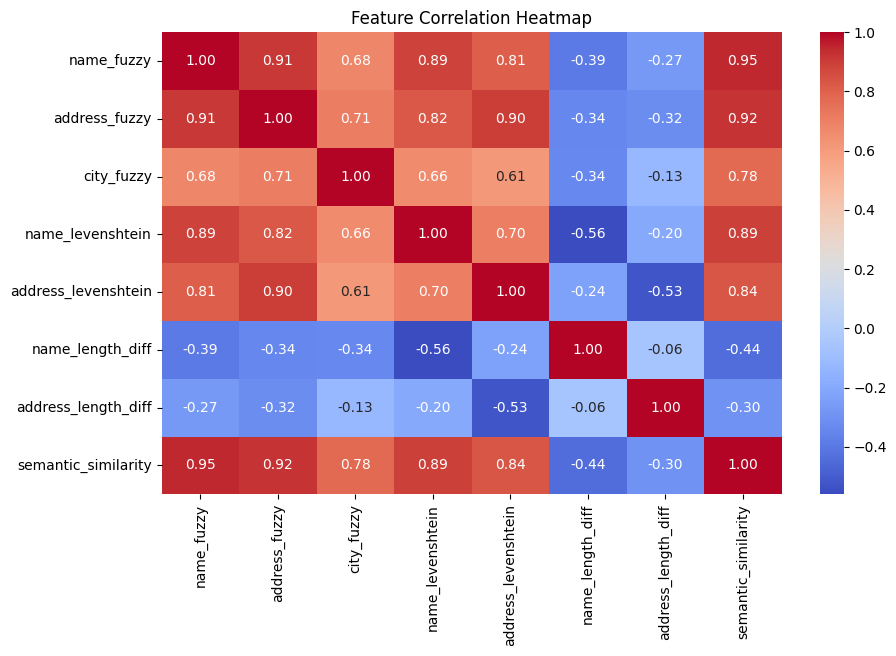

In [37]:
# Check feature correlation
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = features.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In logistic regression, highly correlated features (known as multicolinearity) can lead to unstable coefficient estimates and inflated variance, which, in turn, lead to reduced interpretability of the model. By identifying and removing excessively correlated features, we improve the model's quality without sacrificing significant predictive power.

The correlation heatmap shows that several similarity features are highly correlated, e.g., name_fuzzy and semantic_similarity (0.95) as well as address_fuzzy amd semantic_similarity (0.92). These pairs of features are highly correlated because semantic similarity is an embedding-based measure combining name, address, and city. Similarly, features like name_fuzzy and name_levenshtein are also correlated because they use relatively similar techniques to measure name similarity.

Thus, we need to exclude some fields from the feature set. In order to maintain intepretability and simplicity, we will focus on fuzzy-based and length-based features:
- name_fuzzy
- address_fuzzy
- city_fuzzy
- name_length_diff
- address_length_diff

In [38]:
selected_features = [
    'name_fuzzy',
    'address_fuzzy',
    'city_fuzzy',
    'name_length_diff',
    'address_length_diff'
]


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_selected = features[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, labels, test_size=0.3, random_state=42
)

clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = clf.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\nLogistic Regression Final Evaluation Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")


Logistic Regression Final Evaluation Metrics:
Precision: 1.00
Recall:    1.00
F1-Score:  1.00
Accuracy:  1.00


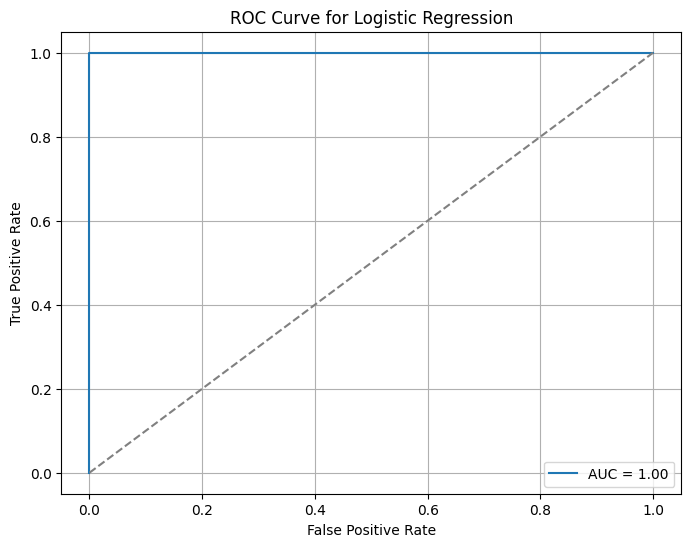

ROC AUC: 1.00


In [50]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate probabilities for ROC
y_probs = clf.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Clearly state AUC
print(f"ROC AUC: {roc_auc:.2f}")

The logistic regression classifier achieved perfect scores (Precision = 1.00, Recall = 1.00, F1-Score = 1.00, Accuracy = 1.00, ROC AUC = 1.00). Due to this exceptional performance, we will conduct a careful verification to rule out errors in the data and model setup.

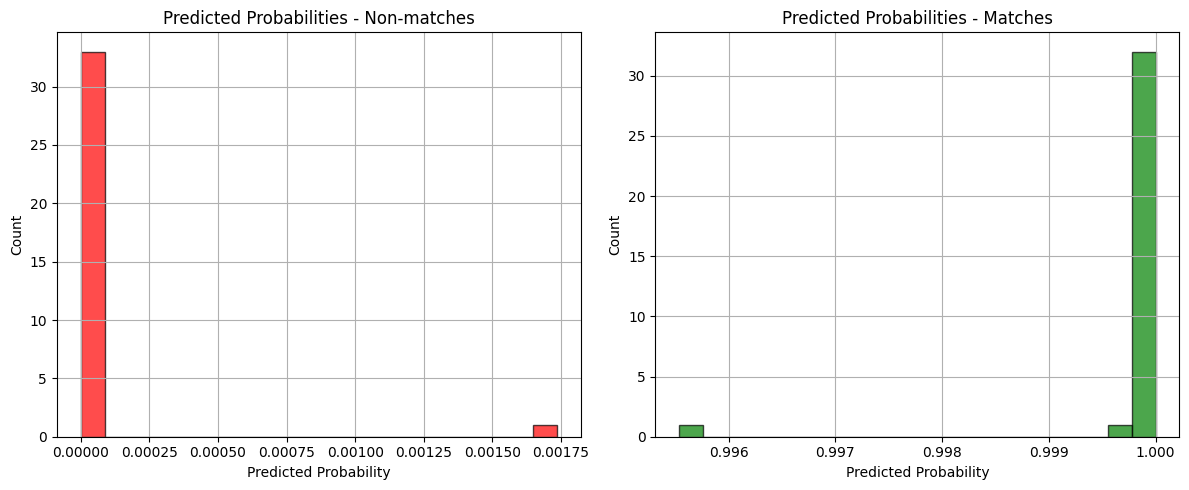

In [ ]:
# Check predicted probabilities distribution

import matplotlib.pyplot as plt

# Predicted probabilities for matches and non-matches separately
match_probs = y_probs[y_test == 1]
non_match_probs = y_probs[y_test == 0]

# Plotting clearly with separate subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Non-matches
ax[0].hist(non_match_probs, bins=20, color='red', alpha=0.7, edgecolor='black')
ax[0].set_title('Predicted Probabilities - Non-matches')
ax[0].set_xlabel('Predicted Probability')
ax[0].set_ylabel('Count')
ax[0].grid()

# Matches
ax[1].hist(match_probs, bins=20, color='green', alpha=0.7, edgecolor='black')
ax[1].set_title('Predicted Probabilities - Matches')
ax[1].set_xlabel('Predicted Probability')
ax[1].set_ylabel('Count')
ax[1].grid()

plt.tight_layout()
plt.show()


All non-match predictions have probabilities extremely close to 0, indicating that the model confidently recognizes these as non-matching pairs. The opposite is true for the match predictions: all of them have probabilities extremely close to 1, demonstrating equally strong confidence in correctly identifying matched pairs.

The histogram of predicted probabilities confirms that the logistic regression model confidently separates matched and unmatched restaurant pairs

In [47]:
# Is there any accidental overlap between train and test sets?
print("Train/Test overlap check:", X_train.index.intersection(X_test.index))

# Are any of the non-matched pairs actually true matches?
non_matches_overlap = pd.merge(non_matched_pairs, matches, how='inner', on=['fodors_id', 'zagats_id'])
print("\nOverlap in negative samples and true matches:", len(non_matches_overlap))

# How many true matches are in train and test sets?
print("\nTrue matches in train set:", y_train.sum())
print("Non-true matches in train set:", len(y_train) - y_train.sum())
print("True matches in test set:", y_test.sum())
print("Non-true matches in test set:", len(y_test) - y_test.sum())

# What are the predicted match counts?
print("\nTrue matches predicted:", y_pred[y_test].sum())
print("False matches predicted:", len(y_pred) - y_pred[y_test].sum())


Train/Test overlap check: Index([], dtype='int64')

Overlap in negative samples and true matches: 0

True matches in train set: 78
Non-true matches in train set: 78
True matches in test set: 34
Non-true matches in test set: 34

True matches predicted: 34
False matches predicted: 34


In [40]:
results_df = X_test.copy()
results_df['actual_match'] = y_test.values
results_df['predicted_match'] = y_pred
results_df['fodors_id'] = all_pairs.iloc[X_test.index]['fodors_id'].values
results_df['zagats_id'] = all_pairs.iloc[X_test.index]['zagats_id'].values

# Examples
print("\nTrue Positives:\n", results_df[(results_df.actual_match) & (results_df.predicted_match)].head(3))
print("\nFalse Positives:\n", results_df[(~results_df.actual_match) & (results_df.predicted_match)].head(3))
print("\nFalse Negatives:\n", results_df[(results_df.actual_match) & (~results_df.predicted_match)].head(3))
print("\nTrue Negatives:\n", results_df[(~results_df.actual_match) & (~results_df.predicted_match)].head(3))



True Positives:
     name_fuzzy  address_fuzzy  city_fuzzy  name_length_diff  \
9        100.0          100.0        42.0               9.0   
84       100.0          100.0       100.0               0.0   
68       100.0          100.0       100.0              10.0   

    address_length_diff  actual_match  predicted_match  fodors_id  zagats_id  
9                   0.0          True             True        543        228  
84                  0.0          True             True        618        303  
68                  0.0          True             True        602        287  

False Positives:
 Empty DataFrame
Columns: [name_fuzzy, address_fuzzy, city_fuzzy, name_length_diff, address_length_diff, actual_match, predicted_match, fodors_id, zagats_id]
Index: []

False Negatives:
 Empty DataFrame
Columns: [name_fuzzy, address_fuzzy, city_fuzzy, name_length_diff, address_length_diff, actual_match, predicted_match, fodors_id, zagats_id]
Index: []

True Negatives:
      name_fuzzy  addres

While it's rare to see results this good in practice, our verification confirmed no methodological issues. The exceptionally clear separation highlights the strength and informativeness of the engineered similarity-based features.

In [62]:
import pandas as pd

# Retrieve model coefficients
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': clf.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Clearly display the coefficients
print("Logistic Regression Model Coefficients:")
print(coefficients)


Logistic Regression Model Coefficients:
               Feature  Coefficient
0           name_fuzzy     0.314598
2           city_fuzzy     0.084391
1        address_fuzzy     0.058068
3     name_length_diff     0.050001
4  address_length_diff    -0.018685


The logistic regression model coefficients indicate the direction and magnitude of each feature's impact on the likelihood that two restaurant records match.

name_fuzzy (coefficient: 0.315) has the strongest positive influence, i.e., higher fuzzy similarity in restaurant names significantly increases the probability of correctly predicting a match. city_fuzzy and address_fuzzy have smaller positive influence.

Surprisingly, name_length_diff (coefficient: 0.050) has a small positive influence, which suggests a slight increase in matching probability with larger differences in restaurant name lengths.

Lastly, address_length_diff (coefficient: -0.019) has a small negative influence. Larger differences in address length slightly decrease the matching likelihood, aligning logically with expectations.

Even though the basic logistic regression provided us with perfect classification, let's demonstrate what running grid search could look like as an exercise.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # Regularization strength: smaller values specify stronger regularization
    'penalty': ['l1', 'l2'], # Reularization type - lasso (L1) or ridge (L2)
    'solver': ['liblinear']  # Required solver for L1 regularization
}

# Initialize and fit
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    scoring='f1',  # optimizing for best F1-score
    cv=5,          # 5-fold cross-validation
    verbose=1      # Show progress
)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.3f}")

# Evaluate optimized model on test data
y_pred_optimized = grid_search.predict(X_test)

precision = precision_score(y_test, y_pred_optimized)
recall = recall_score(y_test, y_pred_optimized)
f1 = f1_score(y_test, y_pred_optimized)
accuracy = accuracy_score(y_test, y_pred_optimized)

# Display final evaluation metrics
print("Optimized Logistic Regression Evaluation Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"Accuracy:  {accuracy:.2f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1-score: 1.000
Optimized Logistic Regression Evaluation Metrics:
Precision: 1.00
Recall:    1.00
F1-Score:  1.00
Accuracy:  1.00


As expected, the optimized set of hyperparameters achieved F1-score = 1.

### Comparative Evaluation


| Method                               | Precision | Recall | F1-Score | Accuracy | Runtime       | API Cost | Scalability | Ease of Implementation |
| ------------------------------------ | --------- | ------ | -------- | -------- | ------------- | -------- | ----------- | ---------------------- |
| **Levenshtein Similarity**           | 0.97      | 0.69   | 0.81     | 1.00     | Fast          | -        | High        | Easy                   |
| **Token Set Ratio**                  | 0.96      | 0.89   | 0.93     | 1.00     | Fast          | -        | High        | Easy                   |
| **TF-IDF + Cosine Similarity**       | 0.86      | 0.93   | 0.89     | 1.00     | Medium        | -        | High        | Medium                 |
| **Sentence-BERT Embeddings**         | 0.93      | 0.96   | 0.94     | 1.00     | Medium        | -        | Medium      | Medium                 |
| **OpenAI GPT-4.1**                   | 1.00      | 0.96   | 0.98     | 0.98     | Slow (95.9s)  | \$0.0212 | Low         | Medium                 |
| **OpenAI GPT-4.1-mini**              | 1.00      | 0.90   | 0.95     | 0.95     | Slow (116.3s) | \$0.0042 | Low         | Medium                 |
| **OpenAI GPT-4.1-nano**              | 1.00      | 0.74   | 0.85     | 0.87     | Slow (84.4s)  | \$0.0011 | Low         | Medium                 |
| **OpenAI o4-mini**                   | 1.00      | 0.94   | 0.97     | 0.97     | Slow (304.2s) | \$0.0552 | Low         | Medium                 |
| **Logistic Regression**              | 1.00      | 1.00   | 1.00     | 1.00     | Medium        | -        | High        | Medium                 |

The key findings are:
- Logistic regression provided perfect performance (Precision, Recall, F1, Accuracy all equal to 1.00), with excellent scalability and low cost, making it ideal for practical use.
- LLM-based matching with GPT-4.1 and o4-mini offered strong semantic understanding, but at a significantly higher cost and slower runtime; using it can oinly be suitable only when precision outweighs cost considerations.
- Embedding-based methods (e.g., Sentence-BERT) balance accuracy and scalability but have higher computational demands compared to simple text-similarity methods.
- Text/token comparison methods proved least effective, but in some case, their ease of use and quickest runtime can be good enough for use.

### Conclusion
